# YOHO training

In [2]:
# Import used libraries

import pandas as pd
print("Pandas version: ", pd.__version__)

import torch
torch.manual_seed(0)

from utils import AudioFile, YOHODataset, YOHODataGenerator

Pandas version:  2.1.2


## Data generator

In [3]:
urbansed_df = YOHODataset(
    audios=[
        AudioFile(filepath=file.filepath, labels=file.events, duration=5, sr=44_100)
        for _, file in pd.read_csv("./data/urbansed.csv").iterrows()
    ]
)

print("x_0: ", urbansed_df[0][0])
print("y_0: ", urbansed_df[0][1])

x_0:  tensor([[[-0.8230, -0.0976,  0.0546,  ..., -0.6622, -0.1024, -1.2878],
         [-0.8233, -0.0986,  0.0539,  ..., -0.6607, -0.1029, -1.2882],
         [-0.8237, -0.1001,  0.0526,  ..., -0.6582, -0.1038, -1.2888],
         ...,
         [-1.4044, -1.3217, -2.1009,  ..., -1.4145, -1.9881, -2.4996],
         [-1.4424, -1.3676, -2.1477,  ..., -1.4281, -2.1152, -2.5762],
         [-1.4942, -1.4530, -2.1418,  ..., -1.4624, -2.2140, -2.7012]]])
y_0:  [('noise', 0, 10.0), ('jackhammer', 3.1254216166103967, 4.081540068079489), ('dog_bark', 4.272822510637965, 5.995148792556066), ('drilling', 4.644565713394142, 7.674565713394141)]


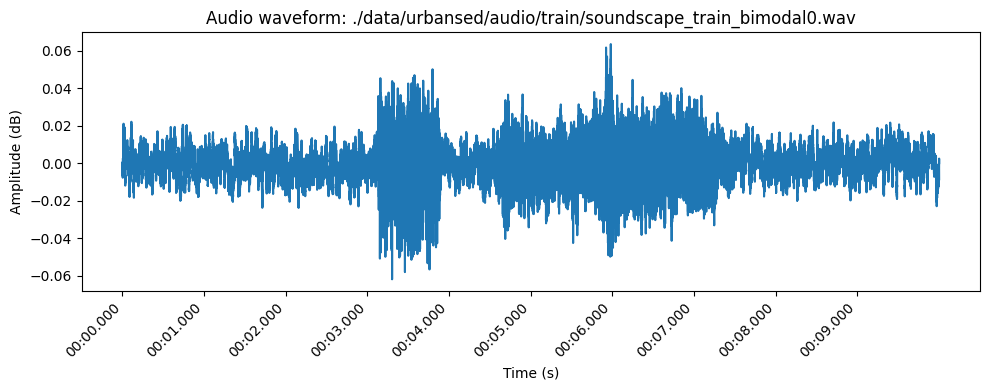

In [4]:
urbansed_df.audios[0].plot()

In [5]:
train_dataloader = YOHODataGenerator(urbansed_df, batch_size=1, shuffle=True)

train_features, train_labels = next(iter(train_dataloader))
train_features, train_labels

(tensor([[[[-1.2173, -0.5937, -0.4628,  ..., -1.3256, -1.0716, -0.6042],
           [-1.2175, -0.5945, -0.4635,  ..., -1.3112, -1.0644, -0.6042],
           [-1.2179, -0.5958, -0.4645,  ..., -1.2889, -1.0530, -0.6043],
           ...,
           [-1.7172, -1.6460, -2.3159,  ..., -1.2052, -1.1771, -1.3190],
           [-1.7498, -1.6855, -2.3561,  ..., -1.2020, -1.1114, -1.4014],
           [-1.7943, -1.7590, -2.3511,  ..., -1.2344, -1.0728, -1.4943]]]]),
 ("[('noise', 0, 10.0), ('street_music', 2.746415593304119, 5.572560610897536), ('jackhammer', 3.578242701949975, 5.962773700434363), ('car_horn', 4.852808255154279, 7.616477860260049), ('gun_shot', 5.596996277018889, 6.324215277018888), ('jackhammer', 6.076060595610772, 7.614903168559016), ('dog_bark', 6.710908004347111, 7.732751405172891), ('siren', 7.085406683277, 9.5606704776191), ('gun_shot', 7.210237848455257, 9.609737848455257), ('gun_shot', 8.03668790669237, 9.80668790669237)]",))

In [6]:
train_features, train_labels = next(iter(train_dataloader))
train_features, train_labels

(tensor([[[[-0.8620, -0.2617, -0.1357,  ..., -0.7241, -0.2643, -1.2495],
           [-0.8622, -0.2625, -0.1363,  ..., -0.7228, -0.2647, -1.2498],
           [-0.8626, -0.2638, -0.1374,  ..., -0.7206, -0.2655, -1.2504],
           ...,
           [-1.3432, -1.2747, -1.9196,  ..., -1.3540, -1.8326, -2.1894],
           [-1.3746, -1.3127, -1.9582,  ..., -1.3644, -1.9363, -2.2524],
           [-1.4174, -1.3834, -1.9534,  ..., -1.3917, -2.0149, -2.3509]]]]),
 ("[('noise', 0, 10.0), ('siren', 2.1688161435155937, 3.708788645004307), ('engine_idling', 4.957180390568066, 5.815470695198912), ('engine_idling', 5.132277516634661, 6.33779061494837), ('jackhammer', 5.399908538681259, 6.027716925087238), ('street_music', 9.249252610765392, 9.833070734254035)]",))